## Modelling Strategy

**Preprocessing**

From all the insights we get from previous EDA section, there are quite many approaches we could try especially on the data preprocessing. For each feature is the data, the strategies could be listed as follows:

1. `id` : dropped
2. `Gender`
    - Kind : Categorical - Nominal
    - Categories no. : 2
    - Preprocessing : One-Hot
3. `Age`
    - Kind: Numerical
    - Distribution : Not normal
    - Preprocessing : 
        - Polynomial with `Vintage`
        - PCAed with `Vintage` and `Annual_Premium`
4. `Driving_License`
    - Kind : Categorical - Ordinal
    - Categories no. : 2
    - Preprocessing : Already represented in integer (1 0)
5. `Region_Code`
    - Kind : Categorical - Nominal
    - Categories no. : Many, with rare labels
    - Preprocessing :
        - Binary, or
        - Rare labels encoding
6. `Previously_Insured`
    - Kind : Categorical - Ordinal
    - Categories no. : 2
    - Preprocessing : Already represented in integer (1 0)
7. `Vehicle_Age`
    - Kind : Categorical - Ordinal
    - Categories no. : 3
    - Preprocessing : One-Hot encoding
8. `Vehicle_Damage`
    - Kind : Categorical - Ordinal
    - Categories no. : 2
    - Preprocessing :
        - One-Hot (with drop first) and label encoding will return similar value
9. `Annual_Premium`
    - Kind : Numerical - Continous
    - Distribution : Not normal, may outliers
    - Preprocessing :
        - Remove outliers and PCA, or
        - Keep outliers and PCA with `Age` and `Vintage`
10. `Policy_Sales_Channel`
    - Kind : Categorical - Nominal
    - Categories no. : Many, with rare labels
    - Preprocessing:
        - Binary, or
        - Rare labels encoding
11. `Vintage`
    - Kind : Numerical - Discrete
    - Distribution: Not Normal
    - Preprocessing:
        - PCAed with `Age` and `Annual_Premium` or,
        - Polynomial with `Age` and `Annual_Premium`
12. `Target`
    - Kind : Categorical
    - Categories no. : 2
    - Preprocessing:
        - Random under-sampling
        - SMOTE
        
**Modelling**

In this project I decide to try three baseline models:
1. Logistic Regression : Represent parametric method
2. Decision Tree : Represent non-parametric method
3. Light Gradient Boosting Classifier : Represent ensemble method

**Evaluation Criteria**

As the business requirement needs the model that precise enough to detect potential customer but not too highly selective I decide to consider multi evaluation criterion such as:
- f1 : This is the main evaluation metric since we want the balance between precision and recall
- AUC : This is the additional metric

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.compose import ColumnTransformer

from scipy import stats

import category_encoders as ce
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve, brier_score_loss, roc_auc_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./archive/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df['Region_Code'] = df['Region_Code'].apply(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(str)

In [4]:
X = df.drop(['id', 'Response'], axis=1)
y = df['Response']

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.3,
                                                            random_state=2021)

In [6]:
X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266776 entries, 371092 to 373928
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                266776 non-null  object 
 1   Age                   266776 non-null  int64  
 2   Driving_License       266776 non-null  int64  
 3   Region_Code           266776 non-null  object 
 4   Previously_Insured    266776 non-null  int64  
 5   Vehicle_Age           266776 non-null  object 
 6   Vehicle_Damage        266776 non-null  object 
 7   Annual_Premium        266776 non-null  float64
 8   Policy_Sales_Channel  266776 non-null  object 
 9   Vintage               266776 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 22.4+ MB


> ### Try base models

In [7]:
def try_models(
    model='lr',
    num='pca',
    region_psc='binary',
    sampling='ros'
):
    oh_enc = OneHotEncoder(drop='first')
    binary_enc = ce.BinaryEncoder()
    rare_encoder = RareLabelCategoricalEncoder(
        tol = 0.05,  # minimal percentage to be considered non-rare
        n_categories = 4, # minimal number of categories the variable should have to re-cgroup rare categories
        variables = ['Region_Code', 'Policy_Sales_Channel'] # variables to re-group
    )  
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    poly = PolynomialFeatures(degree=2)
    ros = RandomOverSampler(random_state=2021)
    smote = SMOTE(random_state=2021)
    
    lr = LogisticRegression()
    dtc = DecisionTreeClassifier()
    lgbm = LGBMClassifier(n_jobs=-1)
    skf = StratifiedKFold(n_splits=5)
    
    if num == 'pca':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('pca', pca)
        ])
    elif num == 'poly':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('poly', poly)
        ])
    
    if region_psc == 'binary':
        region_psc_pipe = Pipeline([
            ('binary', binary_enc)
        ])
    elif region_psc == 'rare':
        region_psc_pipe = Pipeline([
            ('rare', rare_encoder),
            ('binary_rare', binary_enc)
        ])
        
    transformer = ColumnTransformer([
        ('one_hot_encoder', OneHotEncoder(drop='first'), ['Gender', 'Vehicle_Age', 'Vehicle_Damage']),
        ('numerical_prep', num_pipe, ['Age', 'Vintage', 'Annual_Premium']),
        ('region_psc_pred', region_psc_pipe, ['Region_Code', 'Policy_Sales_Channel'])
    ], remainder='passthrough')
    
    if sampling == 'ros':
        res = ros
    elif sampling == 'smote':
        res = smote
    
    if model == 'lr':
        clf = lr
    elif model == 'dtc':
        clf = dtc
    elif model == 'lgbm':
        clf = lgbm
             
    estimator = Pipeline([
        ('preprocess', transformer),
        ('balancing', res),
        ('clf', clf)
    ])
        
    model_cv = cross_validate(estimator, X_train_val, y_train_val, cv=skf, 
                              scoring=('f1', 'roc_auc'))
    
    return estimator, pd.DataFrame(model_cv)

In [8]:
for m in ['lr', 'dtc', 'lgbm']:
    for n in ['pca', 'poly']:
        for rpsc in ['binary', 'rare']:
            for sam in ['ros', 'smote']:
                _ , model_cv = try_models(model=m, num=n, region_psc=rpsc, sampling=sam)
                
                print(f"Mean f1 of {m}_{n}_{rpsc}_{sam} : {model_cv.test_f1.mean()}")
                print(f"Mean roc_auc of {m}_{n}_{rpsc}_{sam} : {model_cv.test_roc_auc.mean()}")
                print(f"STD f1 of {m}_{n}_{rpsc}_{sam} : {model_cv.test_f1.std()}")
                print(f"STD roc_auc of {m}_{n}_{rpsc}_{sam} : {model_cv.test_roc_auc.std()}")
                print("")

Mean f1 of lr_pca_binary_ros : 0.4119998850269407
Mean roc_auc of lr_pca_binary_ros : 0.8317342256737247
STD f1 of lr_pca_binary_ros : 0.0007085230019235256
STD roc_auc of lr_pca_binary_ros : 0.0012754680112566684

Mean f1 of lr_pca_binary_smote : 0.41302760421995216
Mean roc_auc of lr_pca_binary_smote : 0.8318920966617261
STD f1 of lr_pca_binary_smote : 0.0011240438956961018
STD roc_auc of lr_pca_binary_smote : 0.0013668169205493376

Mean f1 of lr_pca_rare_ros : 0.4046959293062472
Mean roc_auc of lr_pca_rare_ros : 0.8263203466446676
STD f1 of lr_pca_rare_ros : 0.0016705637679206302
STD roc_auc of lr_pca_rare_ros : 0.002733668213513657

Mean f1 of lr_pca_rare_smote : 0.4046551532320657
Mean roc_auc of lr_pca_rare_smote : 0.826452079927314
STD f1 of lr_pca_rare_smote : 0.001888667637270041
STD roc_auc of lr_pca_rare_smote : 0.0027249484089845928

Mean f1 of lr_poly_binary_ros : 0.42205057615830127
Mean roc_auc of lr_poly_binary_ros : 0.843901643512775
STD f1 of lr_poly_binary_ros : 0.00

From many trials we've done above, it could be seen that **logistic regression** and **lgbm** are two best base model for our business problem. To sum up, my selections of the preprocessing method falls to:
1. Polynomial - Binary - SMOTE for the Logistic Regression model (f1 = 0.42313)
2. PCA - Binary - SMOTE for LightGBM model (f1 = 0.43329)

To ensure our model selection, let's run this model on the test data

In [18]:
estimator_lr , _ = try_models(model='lr', num='poly', region_psc='binary', sampling='smote')
estimator_lgbm, _ = try_models(model='lgbm', num='pca', region_psc='binary', sampling='smote')

In [19]:
estimator_lr.fit(X_train_val, y_train_val)
y_lr_pred = estimator_lr.predict(X_test)
y_lr_proba = estimator_lr.predict_proba(X_test)[:,1]
print(f'f1 score: {f1_score(y_test, y_lr_pred)}')
print(f'AUC score: {roc_auc_score(y_test, y_lr_proba)}')

f1 score: 0.4253698406211688
AUC score: 0.8456950649522186


In [20]:
estimator_lgbm.fit(X_train_val, y_train_val)
y_lgbm_pred = estimator_lgbm.predict(X_test)
y_lgbm_proba = estimator_lgbm.predict_proba(X_test)[:,1]
print(f'f1 score: {f1_score(y_test, y_lgbm_pred)}')
print(f'AUC score: {roc_auc_score(y_test, y_lgbm_proba)}')

f1 score: 0.43412185876737336
AUC score: 0.8432789692978188


The result we obtained showed the test scores are slightly higher than the train scores, which is a sign of a good model

After this, we going to see how these two set of preprocessing and models perform on the data without any outliers.

> ### Remove outliers on the training data

In [12]:
filtered_entries = np.array([True] * len(X_train_val))

col = 'Annual_Premium'
Q1 = X_train_val[col].quantile(0.25)
Q3 = X_train_val[col].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

filtered_entries = ((X_train_val[col] >= low_limit) & (X_train_val[col] <= high_limit)) & filtered_entries

X_train_val_filtered, y_train_val_filtered = X_train_val[filtered_entries], y_train_val[filtered_entries]

In [13]:
X_train_val.shape, X_train_val_filtered.shape

((266776, 10), (259539, 10))

In [14]:
def try_models_no_out(
    model='lr',
    num='pca',
    region_psc='binary',
    sampling='ros'
):
    oh_enc = OneHotEncoder(drop='first')
    binary_enc = ce.BinaryEncoder()
    rare_encoder = RareLabelCategoricalEncoder(
        tol = 0.05,  # minimal percentage to be considered non-rare
        n_categories = 4, # minimal number of categories the variable should have to re-cgroup rare categories
        variables = ['Region_Code', 'Policy_Sales_Channel'] # variables to re-group
    )  
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    poly = PolynomialFeatures(degree=2)
    ros = RandomOverSampler(random_state=2021)
    smote = SMOTE(random_state=2021)
    
    lr = LogisticRegression()
    dtc = DecisionTreeClassifier()
    lgbm = LGBMClassifier(n_jobs=-1)
    skf = StratifiedKFold(n_splits=5)
    
    if num == 'pca':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('pca', pca)
        ])
    elif num == 'poly':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('poly', poly)
        ])
    
    if region_psc == 'binary':
        region_psc_pipe = Pipeline([
            ('binary', binary_enc)
        ])
    elif region_psc == 'rare':
        region_psc_pipe = Pipeline([
            ('rare', rare_encoder),
            ('binary_rare', binary_enc)
        ])
        
    transformer = ColumnTransformer([
        ('one_hot_encoder', OneHotEncoder(drop='first'), ['Gender', 'Vehicle_Age', 'Vehicle_Damage']),
        ('numerical_prep', num_pipe, ['Age', 'Vintage', 'Annual_Premium']),
        ('region_psc_pred', region_psc_pipe, ['Region_Code', 'Policy_Sales_Channel'])
    ], remainder='passthrough')
    
    if sampling == 'ros':
        res = ros
    elif sampling == 'smote':
        res = smote
    
    if model == 'lr':
        clf = lr
    elif model == 'dtc':
        clf = dtc
    elif model == 'lgbm':
        clf = lgbm
             
    estimator = Pipeline([
        ('preprocess', transformer),
        ('balancing', res),
        ('clf', clf)
    ])
        
    model_cv = cross_validate(estimator, X_train_val_filtered, y_train_val_filtered, cv=skf, 
                              scoring=('f1', 'roc_auc'))
    
    return estimator, pd.DataFrame(model_cv)

In [15]:
for m in ['lr', 'dtc', 'lgbm']:
    for n in ['pca', 'poly']:
        for rpsc in ['binary', 'rare']:
            for sam in ['ros', 'smote']:
                _ , model_cv = try_models_no_out(model=m, num=n, region_psc=rpsc, sampling=sam)
                
                print(f"Mean f1 of {m}_{n}_{rpsc}_{sam} : {model_cv.test_f1.mean()}")
                print(f"Mean roc_auc of {m}_{n}_{rpsc}_{sam} : {model_cv.test_roc_auc.mean()}")
                print(f"STD f1 of {m}_{n}_{rpsc}_{sam} : {model_cv.test_f1.std()}")
                print(f"STD roc_auc of {m}_{n}_{rpsc}_{sam} : {model_cv.test_roc_auc.std()}")
                print("")

Mean f1 of lr_pca_binary_ros : 0.41008973391603687
Mean roc_auc of lr_pca_binary_ros : 0.8315215564818308
STD f1 of lr_pca_binary_ros : 0.004740084362448618
STD roc_auc of lr_pca_binary_ros : 0.0017195938310670313

Mean f1 of lr_pca_binary_smote : 0.41068920140907467
Mean roc_auc of lr_pca_binary_smote : 0.8316863117162985
STD f1 of lr_pca_binary_smote : 0.004318806348198224
STD roc_auc of lr_pca_binary_smote : 0.0017889926676559332

Mean f1 of lr_pca_rare_ros : 0.40751224628667826
Mean roc_auc of lr_pca_rare_ros : 0.826154898289141
STD f1 of lr_pca_rare_ros : 0.007027247934677833
STD roc_auc of lr_pca_rare_ros : 0.002657395229761245

Mean f1 of lr_pca_rare_smote : 0.4060784853964492
Mean roc_auc of lr_pca_rare_smote : 0.8260738101977335
STD f1 of lr_pca_rare_smote : 0.007564084704489096
STD roc_auc of lr_pca_rare_smote : 0.0026811754541837046

Mean f1 of lr_poly_binary_ros : 0.42038265538714
Mean roc_auc of lr_poly_binary_ros : 0.8441716244862569
STD f1 of lr_poly_binary_ros : 0.00456

Although the outliers removal slightly increasing the AUC score of some models, the f1 score is decreasing instead.

To make sure, let's test these models using the test data

In [24]:
estimator_lr , _ = try_models_no_out(model='lr', num='poly', region_psc='binary', sampling='smote')
estimator_lgbm, _ = try_models_no_out(model='lgbm', num='pca', region_psc='binary', sampling='smote')

In [25]:
estimator_lr.fit(X_train_val_filtered, y_train_val_filtered)
y_lr_pred_filtered = estimator_lr.predict(X_test)
y_lr_proba_filtered = estimator_lr.predict_proba(X_test)[:,1]
print(f'f1 score: {f1_score(y_test, y_lr_pred_filtered)}')
print(f'AUC score: {roc_auc_score(y_test, y_lr_proba_filtered)}')

f1 score: 0.4251868081557907
AUC score: 0.844374842365559


In [26]:
estimator_lgbm.fit(X_train_val_filtered, y_train_val_filtered)
y_lgbm_pred_filtered = estimator_lgbm.predict(X_test)
y_lgbm_proba_filtered = estimator_lgbm.predict_proba(X_test)[:,1]
print(f'f1 score: {f1_score(y_test, y_lgbm_pred_filtered)}')
print(f'AUC score: {roc_auc_score(y_test, y_lgbm_proba_filtered)}')

f1 score: 0.4345362467684244
AUC score: 0.8422938066822434


Surprisingly, the outliers removal gives slightly better generalization on the test data for the LightGBM model. Moreover, the cross validation stability of the f1 score is also better (0.4... vs 0.2...)

## Probability Analysis

In [27]:
def plot_calibration_curve(y_true, probs, bins, model):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy='uniform')
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label=type(model).__name__)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=False, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

In [28]:
estimator_lr, _ = try_models(model='lr', num='poly', region_psc='binary', sampling='smote')
estimator_lgbm, _ = try_models(model='lgbm', num='pca', region_psc='binary', sampling='smote')

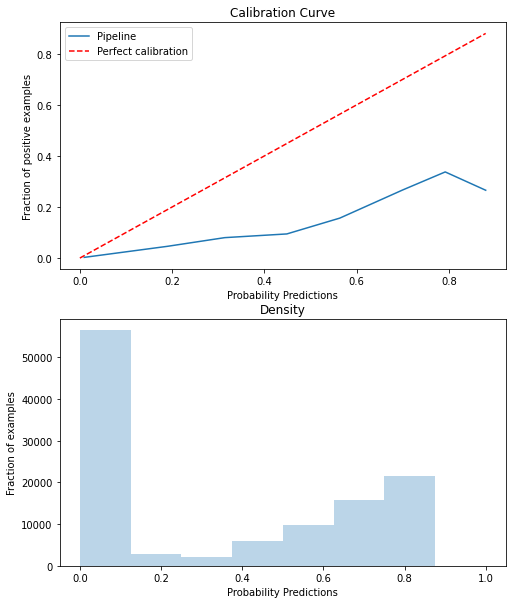

In [29]:
estimator_lr.fit(X_train_val, y_train_val)
lr_proba = estimator_lr.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_proba, bins=8, model=estimator_lr)

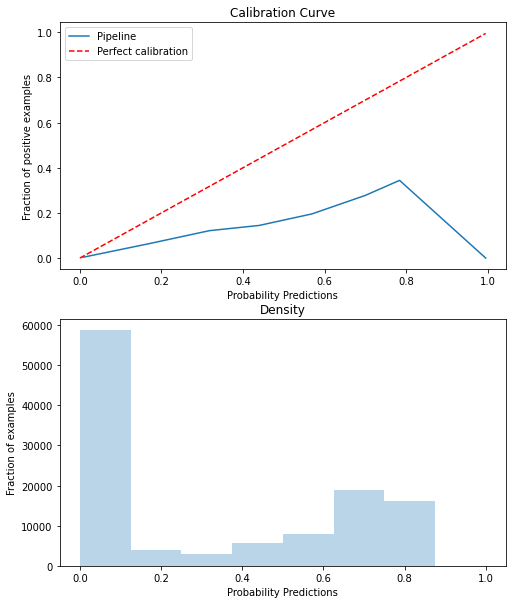

In [30]:
estimator_lgbm.fit(X_train_val, y_train_val)
lgbm_proba = estimator_lgbm.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lgbm_proba, bins=8, model=estimator_lgbm)

> ### Callibrating classifiers

In [31]:
def try_models_callib(
    model='lr',
    num='pca',
    region_psc='binary',
    sampling='ros',
    cal='isotonic'
):
    oh_enc = OneHotEncoder(drop='first')
    binary_enc = ce.BinaryEncoder()
    rare_encoder = RareLabelCategoricalEncoder(
        tol = 0.05,  # minimal percentage to be considered non-rare
        n_categories = 4, # minimal number of categories the variable should have to re-cgroup rare categories
        variables = ['Region_Code', 'Policy_Sales_Channel'] # variables to re-group
    )  
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    poly = PolynomialFeatures(degree=2)
    ros = RandomOverSampler(random_state=2021)
    smote = SMOTE(random_state=2021)
    
    lr = LogisticRegression()
    dtc = DecisionTreeClassifier()
    lgbm = LGBMClassifier(n_jobs=-1)
    skf = StratifiedKFold(n_splits=5)
    
    if num == 'pca':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('pca', pca)
        ])
    elif num == 'poly':
        num_pipe = Pipeline([
            ('scaler', scaler),
            ('poly', poly)
        ])
    
    if region_psc == 'binary':
        region_psc_pipe = Pipeline([
            ('binary', binary_enc)
        ])
    elif region_psc == 'rare':
        region_psc_pipe = Pipeline([
            ('rare', rare_encoder),
            ('binary_rare', binary_enc)
        ])
        
    transformer = ColumnTransformer([
        ('one_hot_encoder', OneHotEncoder(drop='first'), ['Gender', 'Vehicle_Age', 'Vehicle_Damage']),
        ('numerical_prep', num_pipe, ['Age', 'Vintage', 'Annual_Premium']),
        ('region_psc_pred', region_psc_pipe, ['Region_Code', 'Policy_Sales_Channel'])
    ], remainder='passthrough')
    
    if sampling == 'ros':
        res = ros
    elif sampling == 'smote':
        res = smote
    
    if model == 'lr':
        clf = lr
        cal = CalibratedClassifierCV(base_estimator=clf, 
                                     cv=10, method=cal)
    elif model == 'lgbm':
        clf = lgbm
        cal = CalibratedClassifierCV(base_estimator=clf, 
                                     cv=10, method=cal)
        
    estimator = Pipeline([
        ('preprocess', transformer),
        ('balancing', res),
        ('cal', cal)
    ])
        
    model_cv = cross_validate(estimator, X_train_val, y_train_val, cv=skf, 
                              scoring=('f1', 'roc_auc'))
    
    return estimator, pd.DataFrame(model_cv)

In [32]:
estimator_lr_iso, lr_iso_cv = try_models_callib(model='lr', 
                                                num='poly', 
                                                region_psc='binary', 
                                                sampling='smote', 
                                                cal='isotonic')

estimator_lgbm_iso, lgbm_iso_cv = try_models_callib(model='lgbm', 
                                                num='pca', 
                                                region_psc='binary', 
                                                sampling='smote', 
                                                cal='isotonic')

estimator_lr_sig, lr_sig_cv = try_models_callib(model='lr', 
                                                num='poly', 
                                                region_psc='binary', 
                                                sampling='smote', 
                                                cal='sigmoid')

estimator_lgbm_sig, lgbm_sig_cv = try_models_callib(model='lgbm', 
                                                num='pca', 
                                                region_psc='binary', 
                                                sampling='smote', 
                                                cal='sigmoid')

In [33]:
print(f'Mean f1 {lr_iso_cv.test_f1.mean()}') 
print(f'Mean AUC {lr_iso_cv.test_roc_auc.mean()}') 

Mean f1 0.4256810124207693
Mean AUC 0.8434246876939333


In [34]:
print(f'Mean f1 {lgbm_iso_cv.test_f1.mean()}') 
print(f'Mean AUC {lgbm_iso_cv.test_roc_auc.mean()}') 

Mean f1 0.43699464144327893
Mean AUC 0.8423579657285771


In [35]:
print(f'Mean f1 {lr_sig_cv.test_f1.mean()}') 
print(f'Mean AUC {lr_sig_cv.test_roc_auc.mean()}') 

Mean f1 0.4231550726610805
Mean AUC 0.8434364847297724


In [36]:
print(f'Mean f1 {lgbm_sig_cv.test_f1.mean()}') 
print(f'Mean AUC {lgbm_sig_cv.test_roc_auc.mean()}') 

Mean f1 0.4373985179029864
Mean AUC 0.8422010247230111


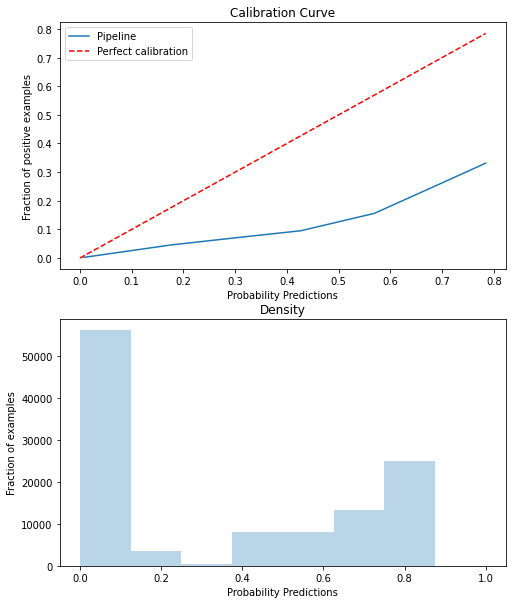

In [37]:
estimator_lr_iso.fit(X_train_val, y_train_val)
lr_iso_proba = estimator_lr_iso.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_iso_proba, bins=8, model=estimator_lr_iso)

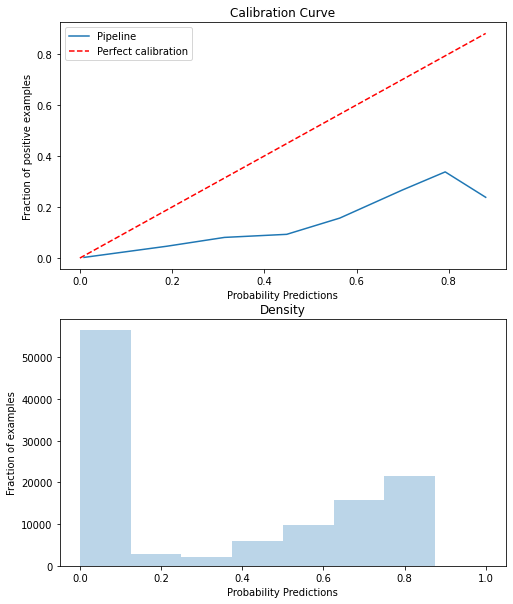

In [38]:
estimator_lr_sig.fit(X_train_val, y_train_val)
lr_iso_proba = estimator_lr_sig.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_iso_proba, bins=8, model=estimator_lr_sig)

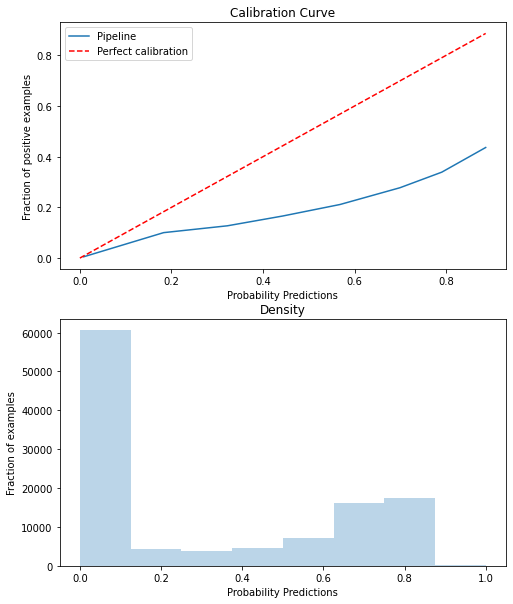

In [39]:
estimator_lgbm_iso.fit(X_train_val, y_train_val)
lgbm_iso_proba = estimator_lgbm_iso.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lgbm_iso_proba, bins=8, model=estimator_lgbm_iso)

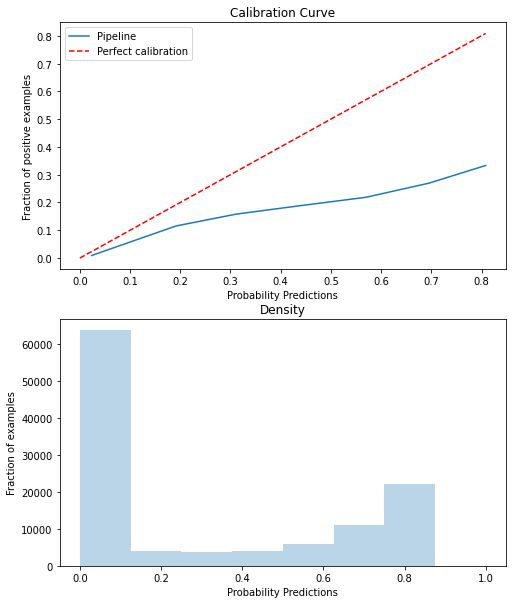

In [40]:
estimator_lgbm_sig.fit(X_train_val, y_train_val)
lgbm_sig_proba = estimator_lgbm_sig.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lgbm_sig_proba, bins=8, model=estimator_lgbm_sig)

## Save model

For further analysis and exploration on the models performance, I decide to save them all

In [41]:
import pickle

In [42]:
pickle.dump(estimator_lr, open('estimator_lr.sav', 'wb'))
pickle.dump(estimator_lgbm, open('estimator_lgbm.sav', 'wb'))
pickle.dump(estimator_lr_iso, open('estimator_lr_iso.sav', 'wb'))
pickle.dump(estimator_lgbm_iso, open('estimator_lgbm_iso.sav', 'wb'))
pickle.dump(estimator_lr_sig, open('estimator_lr_sig.sav', 'wb'))
pickle.dump(estimator_lgbm_sig, open('estimator_lgbm_sig.sav', 'wb'))